### 탄소량 계산

In [ ]:
def calculate_pet_bottle_emission():
    total_emission = 0
    
    # 1. 빨대는 일반쓰레기로 배출
    straw_emission = 0.05  # kg CO2e (예상 배출량)
    total_emission += straw_emission
    print(f"빨대 배출: {straw_emission} kg CO2e")

    # 2. 라벨 제거
    label_emission = 0.02  # kg CO2e (예상 배출량)
    total_emission += label_emission
    print(f"라벨 제거: {label_emission} kg CO2e")

    # 3. 병뚜껑 제거
    cap_emission = 0.01  # kg CO2e (예상 배출량)
    total_emission += cap_emission
    print(f"병뚜껑 제거: {cap_emission} kg CO2e")

    # 4. 플라스틱 배출
    plastic_emission = 0.03  # kg CO2e (예상 배출량)
    total_emission += plastic_emission
    print(f"플라스틱 배출: {plastic_emission} kg CO2e")

    # 수집 및 운반
    collection_transport_emission = 0.1  # kg CO2e (수집 및 운반 과정의 배출량)
    total_emission += collection_transport_emission
    print(f"수집 및 운반: {collection_transport_emission} kg CO2e")

    # 재활용 처리
    recycling_emission = -0.05  # kg CO2e (재활용으로 절감된 배출량)
    total_emission += recycling_emission
    print(f"재활용 처리: {recycling_emission} kg CO2e")

    print(f"총 탄소 배출량: {total_emission:.2f} kg CO2e")

# 함수 실행
calculate_pet_bottle_emission()


### 1. 쓰레기 이미지 수집(구글, 빙)

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics
import os

# 랜덤 시드 설정
seed_num = 11
np.random.seed(seed_num)
torch.manual_seed(seed_num)

# 간소화된 CNN 모델 정의 (Dropout 추가)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=32 * 28 * 28, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Dropout 레이어 추가

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 56 -> 28
        x = x.view(-1, 32 * 28 * 28)          # Flattening
        x = self.dropout(F.relu(self.fc1(x))) # Dropout 적용
        x = self.fc2(x)
        return x

# 데이터 로드 및 전처리
train_dir = "C:\\Project\\Python_basic\\미드나잇\\image"

# 데이터셋 로드
dataset = datasets.ImageFolder(root=train_dir)

In [53]:
# 학습 및 검증용 데이터셋 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 변환 설정 (데이터 증강 추가 강화)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # 회전 각도를 더 크게 조정
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),  # 색상 조정 강화
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # 더 많은 크기 변화를 허용
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # 더 많은 이동 허용
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

In [54]:
# 데이터 로더 설정
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화
num_classes = len(dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes).to(device)

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [55]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs, patience=5, save_path="best_model.pth"):
    train_losses = []
    val_losses = []
    accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # 검증 과정
        model.eval()
        running_val_loss = 0.0
        accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                accuracy_metric.update(outputs, labels)
            accuracy = accuracy_metric.compute()
            accuracies.append(accuracy.item())
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}, Validation loss: {epoch_val_loss:.3f}, accuracy: {accuracy:.2%}')

        # 베스트 모델 저장
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0  # 개선되면 patience 카운터를 리셋
            # 모델 저장
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with validation loss: {best_val_loss:.3f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return train_losses, val_losses, accuracies

# 모델 학습
history = train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=30)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Epoch [1/30] - Training loss: 0.714, Validation loss: 0.684, accuracy: 50.00%
Best model saved with validation loss: 0.684


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Epoch [2/30] - Training loss: 0.682, Validation loss: 0.741, accuracy: 50.00%


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch [3/30] - Training loss: 0.688, Validation loss: 0.745, accuracy: 50.00%


100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


Epoch [4/30] - Training loss: 0.683, Validation loss: 0.735, accuracy: 50.00%


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Epoch [5/30] - Training loss: 0.650, Validation loss: 0.740, accuracy: 53.33%


100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch [6/30] - Training loss: 0.628, Validation loss: 0.751, accuracy: 60.00%
Early stopping at epoch 6


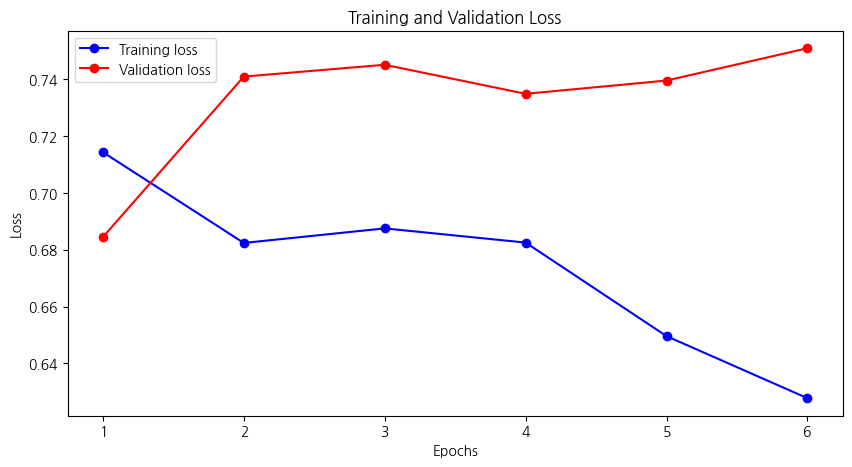

In [56]:
# 학습 및 검증 손실 시각화
train_losses, val_losses, accuracies = history

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, 'bo-', label='Training loss')
plt.plot(epochs_range, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
# 최종 모델 평가
def evaluate(model, data_loader, device):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()
    return accuracy.item()

test_accuracy = evaluate(model, val_loader, device)
print(f'Test Accuracy: {test_accuracy:.2%}')

Test Accuracy: 60.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


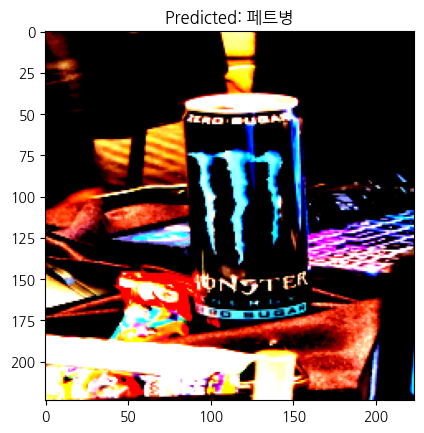

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 페트병


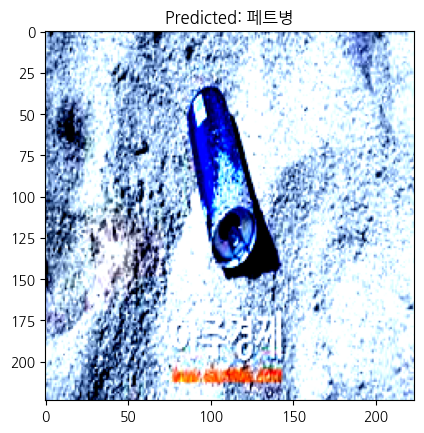

Prediction: 페트병


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


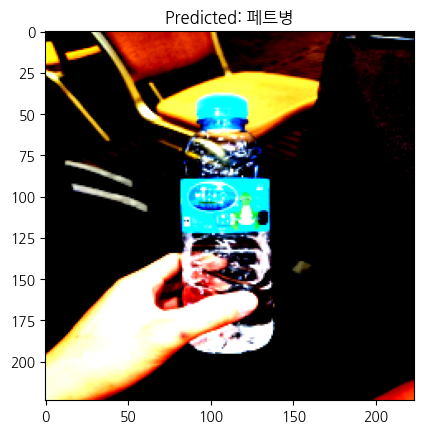

Prediction: 페트병


In [58]:
import os
import koreanize_matplotlib

# 예측 함수
def predict_image(model, image_path, class_names):
    model.eval()
    with torch.no_grad():
        try:
            image = Image.open(image_path)
            image = test_transform(image).unsqueeze(0).to(device)
            outputs = model(image)
            _, preds = torch.max(outputs, 1)

            plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
            plt.title(f'Predicted: {class_names[preds.item()]}')
            plt.show()
            print(f"Prediction: {class_names[preds.item()]}")
        except Exception as e:
            print(f"Error in prediction: {e}")

# 평가할 이미지 파일 경로 설정
image_path1 = "C:\\Project\\Python_basic\\미드나잇\\sad.jpg"
image_path2 = "C:\\Project\\Python_basic\\미드나잇\\캔 쓰레기.jpg"
image_path3 = "C:\\Project\\Python_basic\\미드나잇\\test.jpg"

# 파일 존재 여부 확인 및 예측 수행
for image_path in [image_path1, image_path2, image_path3]:
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Provided path: {image_path}")
    else:
        predict_image(model, image_path, dataset.classes)


#### ________________

In [20]:
# 모델 저장
torch.save(model.state_dict(), "model.pth")

### 바코드 사진 인식(나중에 해결)

In [ ]:
import cv2
from pyzbar.pyzbar import decode

# 바코드와 상품 정보 매핑
barcode_to_product_info = {
    '8809658980975': {
        'product_name': 'Mask',
        'category': 'Health',
        'disposal_method': 'Plastic Recycling'
    },
    '8801234567890': {
        'product_name': 'Bottle',
        'category': 'Drink',
        'disposal_method': 'Glass Recycling'
    },
    '8809876543210': {
        'product_name': 'Snack',
        'category': 'Food',
        'disposal_method': 'General Waste'
    },
    '8809750880069': {  # 마스크팩 바코드 추가
        'product_name': 'Mask Pack',
        'category': 'Cosmetics',
        'disposal_method': 'Plastic Recycling'  # 또는 'General Waste' 등 실제 분리수거 방법
    }
}

def find_product_info(barcode):
    return barcode_to_product_info.get(barcode, None)

def barcode_detection_and_product_info(image_path):
    # 이미지를 로드합니다
    img = cv2.imread(image_path)
    
    # 바코드를 디코딩합니다
    barcodes = decode(img)
    
    for barcode in barcodes:
        x, y, w, h = barcode.rect
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        barcode_data = barcode.data.decode('utf-8')
        product_info = find_product_info(barcode_data)
        
        if product_info is not None:
            text = f"{product_info['product_name']} ({product_info['category']}) - {product_info['disposal_method']}"
            print(f"상품 정보: {text}")
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            print(f"바코드 {barcode_data}에 대한 정보가 없습니다.")
    
    # 결과 이미지를 보여줍니다
    cv2.imshow('Barcode and Product Info', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 바코드 인식 및 정보 출력
barcode_detection_and_product_info('')


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch [1/30] - Training loss: 0.699, Validation loss: 0.637, accuracy: 75.00%


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch [2/30] - Training loss: 0.509, Validation loss: 0.465, accuracy: 83.33%


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [3/30] - Training loss: 0.371, Validation loss: 0.353, accuracy: 91.67%


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [4/30] - Training loss: 0.246, Validation loss: 0.237, accuracy: 91.67%


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [5/30] - Training loss: 0.140, Validation loss: 0.157, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch [6/30] - Training loss: 0.059, Validation loss: 0.096, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


Epoch [7/30] - Training loss: 0.028, Validation loss: 0.073, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [8/30] - Training loss: 0.014, Validation loss: 0.063, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch [9/30] - Training loss: 0.008, Validation loss: 0.059, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch [10/30] - Training loss: 0.005, Validation loss: 0.048, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [11/30] - Training loss: 0.003, Validation loss: 0.048, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


Epoch [12/30] - Training loss: 0.003, Validation loss: 0.041, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch [13/30] - Training loss: 0.002, Validation loss: 0.038, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch [14/30] - Training loss: 0.002, Validation loss: 0.039, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch [15/30] - Training loss: 0.001, Validation loss: 0.038, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


Epoch [16/30] - Training loss: 0.001, Validation loss: 0.034, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  3.00it/s]


Epoch [17/30] - Training loss: 0.001, Validation loss: 0.035, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch [18/30] - Training loss: 0.001, Validation loss: 0.030, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch [19/30] - Training loss: 0.001, Validation loss: 0.036, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch [20/30] - Training loss: 0.001, Validation loss: 0.033, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [21/30] - Training loss: 0.001, Validation loss: 0.033, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch [22/30] - Training loss: 0.000, Validation loss: 0.036, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch [23/30] - Training loss: 0.000, Validation loss: 0.031, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


Epoch [24/30] - Training loss: 0.000, Validation loss: 0.032, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch [25/30] - Training loss: 0.000, Validation loss: 0.036, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch [26/30] - Training loss: 0.000, Validation loss: 0.033, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [27/30] - Training loss: 0.000, Validation loss: 0.034, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [28/30] - Training loss: 0.000, Validation loss: 0.033, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch [29/30] - Training loss: 0.000, Validation loss: 0.032, accuracy: 100.00%


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

Epoch [30/30] - Training loss: 0.000, Validation loss: 0.033, accuracy: 100.00%


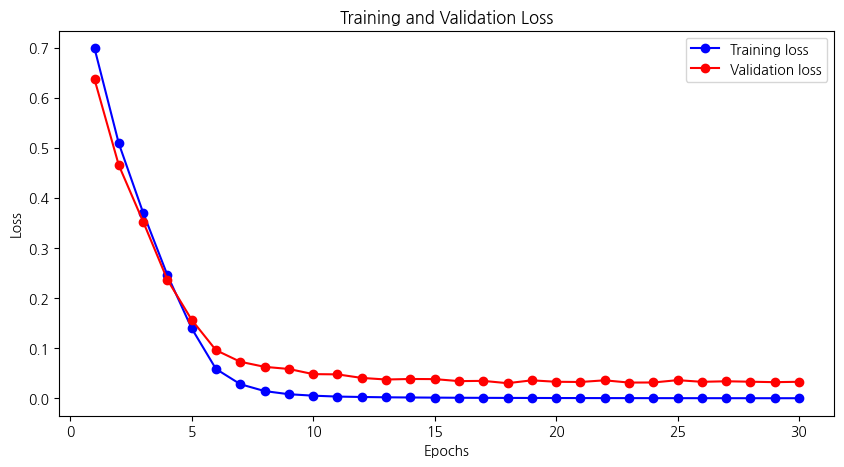

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Accuracy: 100.00%
Error: The file C:\Project\Python_basic\미드나잇\페트병 스레기.jpg does not exist.
Current working directory: c:\Project\Python_basic\미드나잇
Provided path: C:\Project\Python_basic\미드나잇\페트병 스레기.jpg


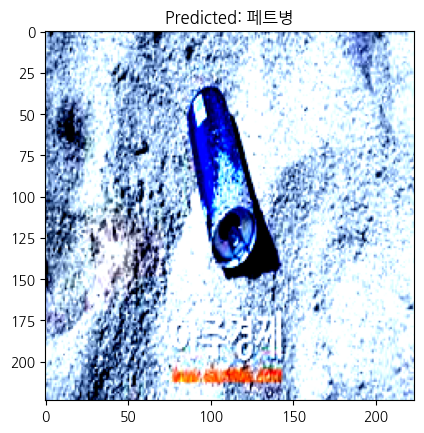

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 페트병


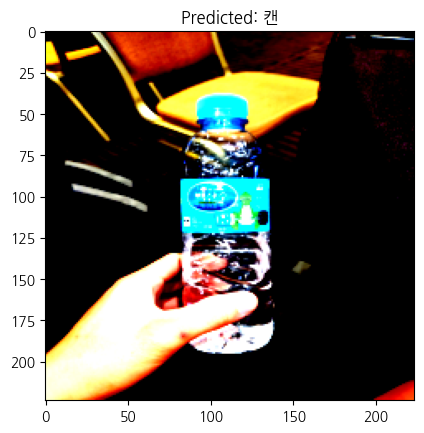

Prediction: 캔


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics

# 랜덤 시드 설정
seed_num = 11
np.random.seed(seed_num)
torch.manual_seed(seed_num)

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 56 -> 28
        x = x.view(-1, 64 * 28 * 28)          # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 데이터 로드 및 전처리
train_dir = "C:\\Project\\Python_basic\\미드나잇\\additional_images"

# 데이터셋 로드
dataset = datasets.ImageFolder(root=train_dir)

# 데이터셋 로드
dataset = datasets.ImageFolder(root=train_dir)

# 학습 및 검증용 데이터셋 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 변환 설정
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

# 데이터 로더 설정
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화
num_classes = len(dataset.classes)
model = SimpleCNN(num_classes=num_classes).to(device)

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 모델 학습 함수
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # 검증 과정
        model.eval()
        running_val_loss = 0.0
        accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                accuracy_metric.update(outputs, labels)
            accuracy = accuracy_metric.compute()
            accuracies.append(accuracy.item())
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}, Validation loss: {epoch_val_loss:.3f}, accuracy: {accuracy:.2%}')

    return train_losses, val_losses, accuracies

# 모델 학습
history = train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=30)


# 학습 및 검증 손실 시각화
train_losses, val_losses, accuracies = history

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, 'bo-', label='Training loss')
plt.plot(epochs_range, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 최종 모델 평가
def evaluate(model, data_loader, device):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()
    return accuracy.item()

test_accuracy = evaluate(model, val_loader, device)
print(f'Test Accuracy: {test_accuracy:.2%}')

import os
import koreanize_matplotlib

# 예측 함수
def predict_image(model, image_path, class_names):
    model.eval()
    with torch.no_grad():
        try:
            image = Image.open(image_path)
            image = test_transform(image).unsqueeze(0).to(device)
            outputs = model(image)
            _, preds = torch.max(outputs, 1)

            plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
            plt.title(f'Predicted: {class_names[preds.item()]}')
            plt.show()
            print(f"Prediction: {class_names[preds.item()]}")
        except Exception as e:
            print(f"Error in prediction: {e}")

# 평가할 이미지 파일 경로 설정
image_path1 = "C:\\Project\\Python_basic\\미드나잇\\페트병 스레기.jpg"
image_path2 = "C:\\Project\\Python_basic\\미드나잇\\캔 쓰레기.jpg"
image_path3 = "C:\\Project\\Python_basic\\미드나잇\\test.jpg"

# 파일 존재 여부 확인 및 예측 수행
for image_path in [image_path1, image_path2, image_path3]:
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Provided path: {image_path}")
    else:
        predict_image(model, image_path, dataset.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


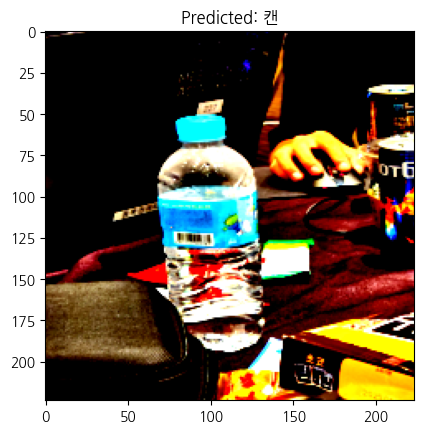

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 캔


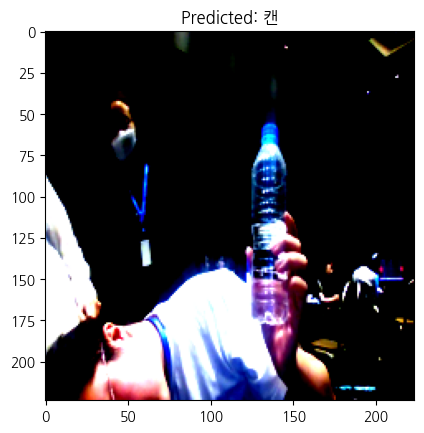

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 캔


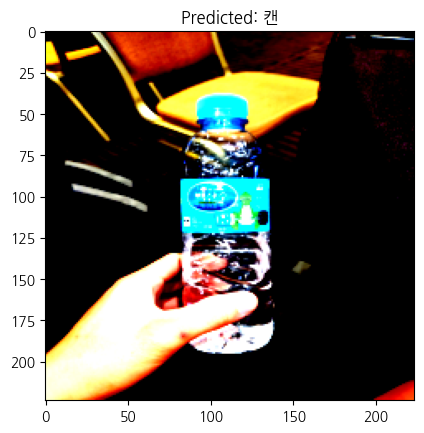

Prediction: 캔


In [61]:
# 예측 함수
def predict_image(model, image_path, class_names):
    model.eval()
    with torch.no_grad():
        try:
            image = Image.open(image_path)
            image = test_transform(image).unsqueeze(0).to(device)
            outputs = model(image)
            _, preds = torch.max(outputs, 1)

            plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
            plt.title(f'Predicted: {class_names[preds.item()]}')
            plt.show()
            print(f"Prediction: {class_names[preds.item()]}")
        except Exception as e:
            print(f"Error in prediction: {e}")

# 평가할 이미지 파일 경로 설정
image_path1 = "C:\\Project\\Python_basic\\미드나잇\\KakaoTalk_20240821_234752307.jpg"
image_path2 = "C:\\Project\\Python_basic\\미드나잇\\decoded_image.png"
image_path3 = "C:\\Project\\Python_basic\\미드나잇\\test.jpg"

# 파일 존재 여부 확인 및 예측 수행
for image_path in [image_path1, image_path2, image_path3]:
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Provided path: {image_path}")
    else:
        predict_image(model, image_path, dataset.classes)

In [ ]:
# 모델 저장
torch.save(model.state_dict(), "model.pth")